## - Import libaries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, utils, models
from torch.utils.data import Dataset
from torchsummary import summary
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import copy

## - Set GPU Envrionment

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

## - Set Hyper-parameters
  

In [3]:
# For Training
EPOCHS     =10
BATCH_SIZE = 128

# For Optimizer
LR         = 0.001
MOMENTUM   = 0.9

## - Prepare the Dataset

In [4]:

transform = transforms.Compose([

    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
img_train_data = []
for d, l in  trainset:
    if l == 0:
        img_train_data.append([d, 0 ])
    elif l == 1:
        img_train_data.append([d, 1 ])

In [6]:
img_train_data = np.array(img_train_data)
img_train_data.shape

<ipython-input-6-f399375836df>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  img_train_data = np.array(img_train_data)
<ipython-input-6-f399375836df>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  img_train_data = np.array(img_train_data)


(10000, 2)

In [7]:
img_train_data[0][0].shape, img_train_data[0][1]

(torch.Size([3, 32, 32]), 1)

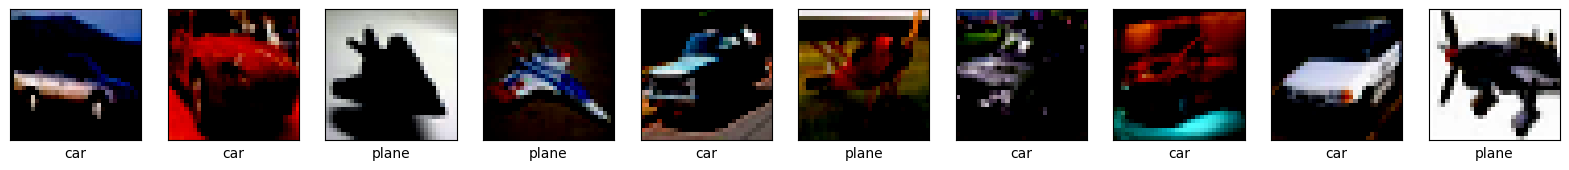

In [8]:
class_names = ['plane', 'car']

np.random.seed(15)
torch.manual_seed(0)

grid_size = 10

plt.figure(figsize=(20,200))
for i in range(grid_size):
    plt.subplot(1,grid_size,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(img_train_data[i][0]).transpose([1, 2, 0]))
    plt.xlabel(class_names[img_train_data[i][1]])
plt.show()


In [9]:
img_test_data = []
for d, l in  testset:
    if l == 0:
        img_test_data.append([d, 0 ])
    elif l == 1:
        img_test_data.append([d, 1 ])

## - Make CustomDataSet

In [10]:
class CustomDataset(Dataset):
  def __init__(self, new_dataset_raw, transform):
    self.data = new_dataset_raw
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    x = self.transform(self.data[idx][0])
    y = torch.tensor(self.data[idx][1])
    return x, y


In [11]:

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

train_loader = torch.utils.data.DataLoader(
    CustomDataset(
        img_train_data,
        transform = transform_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory = True
)


test_loader = torch.utils.data.DataLoader(
    CustomDataset(
        img_test_data,
        transform = transform_test),
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory = True
)

## - Prepare a Model for Whole training

https://pytorch.org/vision/stable/models.html

In [13]:
model_ft = models.resnet18(pretrained=True)


In [15]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=LR, momentum=MOMENTUM)


## - Training the Whole Model

In [19]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()


        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [20]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [21]:
for epoch in range(1, 20):
    train(model_ft, train_loader, optimizer_ft, epoch)
    test_loss, test_accuracy = evaluate(model_ft, test_loader)
    exp_lr_scheduler.step()

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format( epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/10000 (0%)]	Loss: 0.359521
[1] Test Loss: 0.2640, Accuracy: 89.45%
Train Epoch: 2 [0/10000 (0%)]	Loss: 0.319905
[2] Test Loss: 0.2469, Accuracy: 89.80%
Train Epoch: 3 [0/10000 (0%)]	Loss: 0.311313
[3] Test Loss: 0.2309, Accuracy: 91.05%
Train Epoch: 4 [0/10000 (0%)]	Loss: 0.269056
[4] Test Loss: 0.2200, Accuracy: 91.05%
Train Epoch: 5 [0/10000 (0%)]	Loss: 0.140007
[5] Test Loss: 0.2077, Accuracy: 92.15%
Train Epoch: 6 [0/10000 (0%)]	Loss: 0.181559
[6] Test Loss: 0.2084, Accuracy: 91.45%
Train Epoch: 7 [0/10000 (0%)]	Loss: 0.154798
[7] Test Loss: 0.2240, Accuracy: 91.05%
Train Epoch: 8 [0/10000 (0%)]	Loss: 0.269540
[8] Test Loss: 0.1971, Accuracy: 92.90%
Train Epoch: 9 [0/10000 (0%)]	Loss: 0.181900
[9] Test Loss: 0.1962, Accuracy: 92.35%
Train Epoch: 10 [0/10000 (0%)]	Loss: 0.165134
[10] Test Loss: 0.1912, Accuracy: 92.70%
Train Epoch: 11 [0/10000 (0%)]	Loss: 0.128783
[11] Test Loss: 0.1920, Accuracy: 92.60%
Train Epoch: 12 [0/10000 (0%)]	Loss: 0.120579
[12] Test Loss:

## - Predict and Visualize

In [22]:
def visualize(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(20,200))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))

                plt.imshow( inputs[j].detach().cpu().numpy().transpose([1,2,0]) )

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

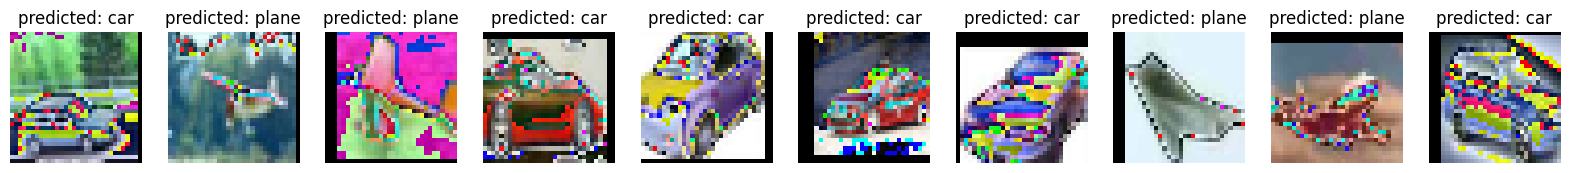

In [23]:
visualize(model_ft)

In [25]:
torch.save(model_ft.state_dict(), 'cifar10_best.pt')

## - Prepare a Model for only Classifier Training (ConvNet as Fixed Feature Extractor)

https://pytorch.org/vision/stable/models.html

In [76]:
model_conv = models.resnet18()
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=LR, momentum=MOMENTUM)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## - Training only the Classifier

In [77]:

for epoch in range(1,2):
    train(model_ft, train_loader, optimizer_ft, epoch, exp_lr_scheduler)
    test_loss, test_accuracy = evaluate(model_ft, test_loader)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format( epoch, test_loss, test_accuracy))

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train Epoch: 1 [0/10000 (0%)]	Loss: 0.451370
[1] Test Loss: 0.4733, Accuracy: 80.70%


In [78]:
torch.save(model_ft.state_dict(), 'cifar10_best.pt')

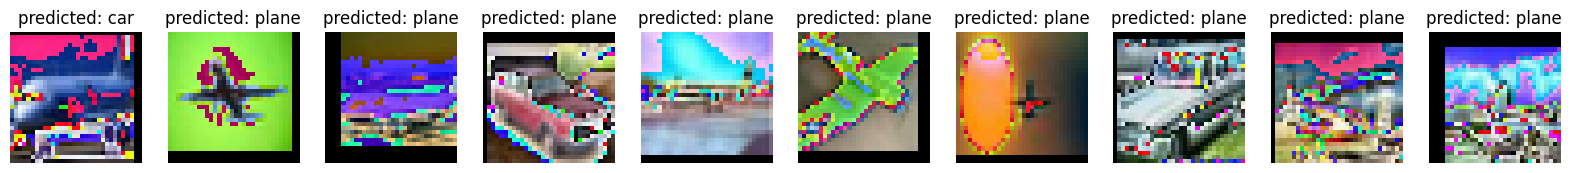

In [79]:
visualize(model_conv)

## - Save & Load

In [80]:
# # Save model
# torch.save(model_ft, 'transferresnet.pt')

In [26]:
tmp = torch.load('cifar10_best.pt')
model_ft.load_state_dict(tmp)
model_ft = model_ft.to(DEVICE)

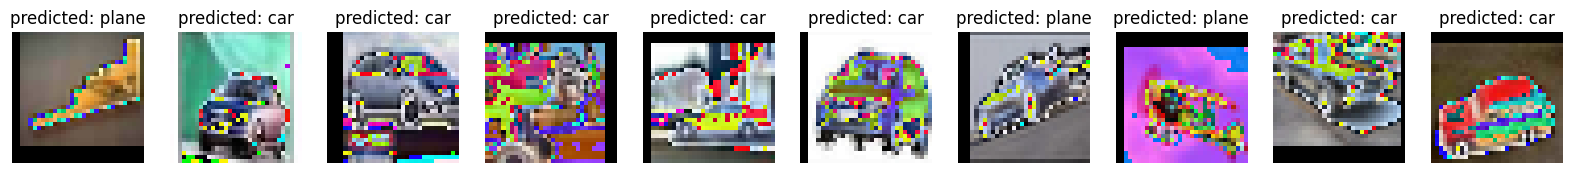

In [27]:
visualize(model_ft  )

In [28]:
modules=list(model_ft.children())[:-1]
backbone=nn.Sequential(*modules)

In [29]:
classifier = model_ft.fc

In [30]:
backbone = backbone.to(DEVICE)
classifier = classifier.to(DEVICE)

In [31]:
from sklearn.metrics import confusion_matrix
tot_acc = []
tot_cls_acc = []
all_feature = []

backbone.eval()
classifier.eval()

all_preds = []
all_targets = []

confidence = np.array([])
pred_class = np.array([])
true_class = np.array([])
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in train_loader:

        data, target = data.to(DEVICE), target.to(DEVICE)
        #feat_mlp, output, centers_mlp, feat = model(data)
        feat = backbone(data)
        feat = feat.squeeze()
        output = classifier(feat)
        #output, feat = model(data)

        try:
            all_feature = np.concatenate( (all_feature, feat.cpu().numpy()),  axis=0)
        except:
            all_feature = feat.cpu().numpy()

        test_loss += F.cross_entropy(output, target, reduction='sum').item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()


        prob = torch.softmax(output, dim=1)
        confidence_part, pred_class_part = torch.max(prob, dim=1)
        confidence = np.append(confidence, confidence_part.cpu().numpy())
        pred_class = np.append(pred_class, pred_class_part.cpu().numpy())
        true_class = np.append(true_class, target.cpu().numpy())

        _, pred = torch.max(output, 1)
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    cf = confusion_matrix(all_targets, all_preds).astype(float)
    cls_cnt = cf.sum(axis=1)
    cls_hit = np.diag(cf)
    cls_acc = cls_hit / cls_cnt



print(f'correct_classes : {cls_acc}' )
test_loss /= len(train_loader.dataset)
test_accuracy = 100. * correct / len(train_loader.dataset)

tot_acc.append(test_accuracy)
tot_cls_acc.append(cls_acc)



correct_classes : [0.9578 0.9544]


In [32]:
cf

array([[4789.,  211.],
       [ 228., 4772.]])

In [33]:
all_feature.shape

(10000, 512)

In [34]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(all_feature.squeeze())))
actual = np.array(all_targets)


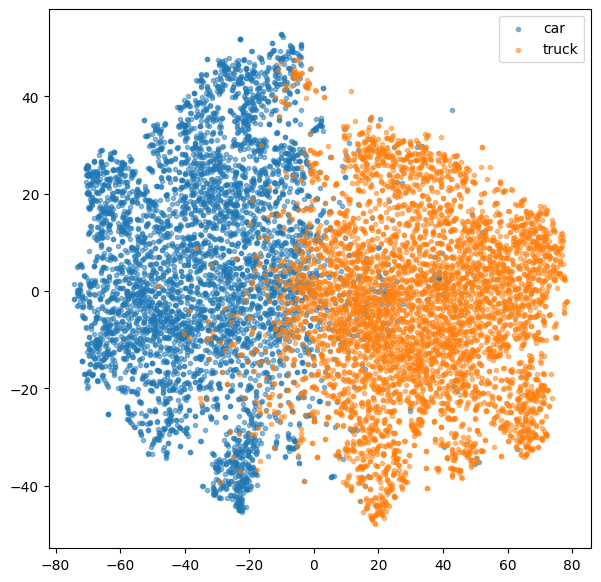

In [35]:
plt.figure(figsize=(7, 7))
cifar = [  'car',     'truck']
for i, label in zip(range(2), cifar):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha=0.5)

plt.legend()
plt.show()